# Cross-Source Feature Comparisons

In [60]:
%run -m ipy_startup
%run -m ipy_logging
%run -m ipy_plotly
%run -m ipy_seaborn
%matplotlib inline
from mgds.data_aggregation import api
from mgds.data_aggregation import database as db
from mgds.data_aggregation import source as src
from mgds.data_aggregation import data_type as dtyp
from mgds.data_aggregation import entity
from mgds.data_modeling import data_broker as dbm
from mgds.data_modeling import training01 as rx_train
from mgds.data_modeling import data as feature_data

2017-03-21 11:21:42,070:DEBUG:requests.packages.urllib3.connectionpool: Starting new HTTPS connection (1): api.plot.ly
2017-03-21 11:21:42,070:DEBUG:requests.packages.urllib3.connectionpool: Starting new HTTPS connection (1): api.plot.ly


# AUC Comparison (CTD vs GDSC)

In [2]:
d1 = api.get_raw_genomic_data(src.CTD_v2, dtyp.DRUG_SENSITIVITY)
#d1 = db.load(src.CTD_v2, db.IMPORT, 'drug-sensitivity')
d1.info()

2017-03-20 12:20:37,045:WARNING:mgds.data_aggregation.api: Genomic data for source "ctd_v2" and data type "drug-sensitivity" has a cell line mapping but does not have a primary site mapping (so all primary site fields will be null)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 395263 entries, 0 to 395262
Data columns (total 15 columns):
CELL_LINE_ID           395263 non-null object
CELL_LINE_ID:CTD       395263 non-null int64
DRUG_ID:CTD            395263 non-null int64
SMILES                 395263 non-null object
DRUG_NAME              395263 non-null object
STATUS                 395263 non-null object
DRUG_ID:BROAD          395263 non-null object
AUC                    395263 non-null float64
LOG2_EC50              395263 non-null float64
EXPERIMENT_ID          395263 non-null int64
CELL_LINE_ID:MGDS      395263 non-null object
PRIMARY_SITE:SOURCE    0 non-null object
PRIMARY_SITE:MGDS      0 non-null object
DRUG_NAME:MGDS         395263 non-null object
DRUG_NAME:SOURCE       395263 non-null object
dtypes: float64(2), int64(3), object(10)
memory usage: 48.2+ MB


In [3]:
d2 = api.get_raw_genomic_data(src.GDSC_v2, dtyp.DRUG_SENSITIVITY)
#d2 = db.load(src.GDSC_v2, db.IMPORT, 'drug-sensitivity')
d2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212665 entries, 0 to 212664
Data columns (total 17 columns):
IC50_RESULTS_ID        212665 non-null object
CELL_LINE_ID:COSMIC    212665 non-null object
DRUG_ID:COSMIC         212665 non-null int64
MAX_CONC_MICROMOLAR    212665 non-null float64
LN_IC50                212665 non-null float64
AUC                    212665 non-null float64
RMSE                   212665 non-null float64
DRUG_NAME              212665 non-null object
SYNONYMS               113092 non-null object
TARGET                 211696 non-null object
TARGET_PATHWAY         212665 non-null object
CELL_LINE_ID           205148 non-null object
CELL_LINE_ID:MGDS      205148 non-null object
PRIMARY_SITE:MGDS      205148 non-null object
PRIMARY_SITE:SOURCE    205148 non-null object
DRUG_NAME:MGDS         212665 non-null object
DRUG_NAME:SOURCE       212665 non-null object
dtypes: float64(4), int64(1), object(12)
memory usage: 29.2+ MB


In [4]:
from py_utils import set_utils
set_res = set_utils.analyze_sets(d1['DRUG_NAME:MGDS'].unique(), d2['DRUG_NAME:MGDS'].unique(), items=True)

In [5]:
drugs = set_res['Items']['InBoth']

In [6]:
d1.groupby(['CELL_LINE_ID:MGDS', 'DRUG_NAME:MGDS']).size().value_counts()

1    379422
2      7283
3       425
dtype: int64

In [7]:
d = pd.concat([
    d1.groupby(['CELL_LINE_ID:MGDS', 'DRUG_NAME:MGDS'])['AUC'].mean().rename('AUC:CTD'),
    d2.groupby(['CELL_LINE_ID:MGDS', 'DRUG_NAME:MGDS'])['AUC'].mean().rename('AUC:GDSC'),
], join='inner', axis=1)
d.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 36037 entries, (22RV1, 17AAG) to (ZR7530, VORINOSTAT)
Data columns (total 2 columns):
AUC:CTD     36037 non-null float64
AUC:GDSC    36037 non-null float64
dtypes: float64(2)
memory usage: 674.0+ KB


In [8]:
d.describe()

AUC:CTD      AUC:GDSC
count  36037.000000  36037.000000
mean      12.064085      0.816141
std        2.655791      0.217821
min        0.069100      0.008591
25%       10.795000      0.738899
50%       12.581000      0.907625
75%       13.968000      0.974089
max       20.000000      0.998639

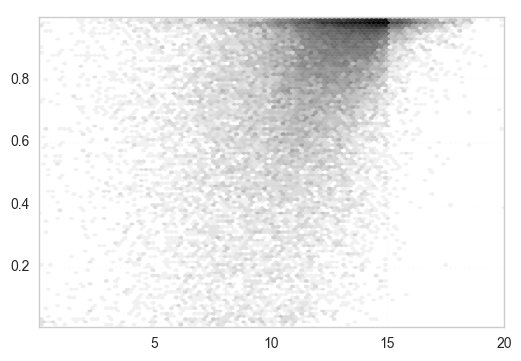

In [12]:
plt.hexbin(d['AUC:CTD'], d['AUC:GDSC'], bins='log')

# TCGA Gene Names vs Other Sources

In [13]:
# Load data from data_modeling/prep/tcga-prep.ipynb
d = db.load_obj(src.TCGA_v1, db.PREP, 'raw-data-matrices')
d.keys()

2017-03-20 14:05:11,755:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/prep/tcga_v1_raw-data-matrices.pkl"


dict_keys(['gene-rna-seq', 'gene-rppa', 'gene-copy-number', 'gene-methylation', 'gene-exome-seq', 'gene-expression'])

In [14]:
d['gene-expression'].info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 529 entries, (brca, TCGA-A1-A0SD-01) to (brca, TCGA-E2-A1BD-01)
Columns: 16810 entries, A1BG to ZZZ3
dtypes: float64(16810)
memory usage: 67.8+ MB


In [ ]:
from py_utils import set_utils

In [20]:
def compare_gene_sets(tcga_dtyp, dat_src, dat_typ):
    d1 = d[tcga_dtyp].columns.tolist()
    d2 = api.get_raw_genomic_data(dat_src, dat_typ)['GENE_ID:HGNC'].unique()
    return set_utils.analyze_sets(d1, d2, items=True)

In [21]:
compare_gene_sets(dtyp.GENE_EXPRESSION, src.CCLE_v1, dtyp.GENE_EXPRESSION)['Stats']

{'All': '18165 (100%)',
 'InBoth': '14687 (80.85%)',
 'InOnlyOne': '3478 (19.15%)',
 'InOnlySet1': '2123 (11.69%)',
 'InOnlySet2': '1355 (7.46%)'}

In [22]:
compare_gene_sets(dtyp.GENE_EXPRESSION, src.GDSC_v2, dtyp.GENE_EXPRESSION)['Stats']

{'All': '19187 (100%)',
 'InBoth': '15042 (78.40%)',
 'InOnlyOne': '4145 (21.60%)',
 'InOnlySet1': '1768 (9.21%)',
 'InOnlySet2': '2377 (12.39%)'}

In [27]:
compare_gene_sets(dtyp.GENE_COPY_NUMBER, src.CCLE_v1, dtyp.GENE_COPY_NUMBER)['Stats']

{'All': '24037 (100%)',
 'InBoth': '19626 (81.65%)',
 'InOnlyOne': '4411 (18.35%)',
 'InOnlySet1': '3656 (15.21%)',
 'InOnlySet2': '755 (3.14%)'}

# CCLE vs GDSC Gene Expression

In [32]:
d1 = api.get_raw_genomic_data(src.CCLE_v1, dtyp.GENE_EXPRESSION)
d2 = api.get_raw_genomic_data(src.GDSC_v2, dtyp.GENE_EXPRESSION)

# Restrict to shared genes
genes = np.intersect1d(d1['GENE_ID:HGNC'].unique(), d2['GENE_ID:HGNC'].unique())
d1 = d1[d1['GENE_ID:HGNC'].isin(genes)]
d2 = d2[d2['GENE_ID:HGNC'].isin(genes)]

In [48]:
# Resolve duplicates
idx = ['CELL_LINE_ID:MGDS', 'GENE_ID:HGNC']

cts = d1.groupby(idx)['VALUE'].nunique()
assert cts.max() == 1
d1 = d1.groupby(idx).first().reset_index()

cts = d2.groupby(idx)['VALUE'].nunique()
assert cts.value_counts().index.max() == 1
d2 = d2.groupby(idx).first().reset_index()

In [50]:
# Join CCLE to GDSC
cols = ['PRIMARY_SITE:MGDS', 'VALUE'] 
d = pd.concat([
    d1.set_index(idx)[cols].add_prefix('ccle:'),
    d2.set_index(idx)[cols].add_prefix('gdsc:')
], axis=1, join='inner')
d.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8823692 entries, (22RV1, A1BG) to (ZR7530, ZZZ3)
Data columns (total 4 columns):
ccle:PRIMARY_SITE:MGDS    object
ccle:VALUE                float64
gdsc:PRIMARY_SITE:MGDS    object
gdsc:VALUE                float64
dtypes: float64(2), object(2)
memory usage: 303.1+ MB


In [51]:
assert np.all(d['ccle:PRIMARY_SITE:MGDS'].notnull())
assert np.all(d['gdsc:PRIMARY_SITE:MGDS'].notnull())
assert np.all(d['ccle:PRIMARY_SITE:MGDS'] == d['gdsc:PRIMARY_SITE:MGDS'])
d = d.rename(columns={'gdsc:PRIMARY_SITE:MGDS': 'PRIMARY_SITE'}).drop('ccle:PRIMARY_SITE:MGDS', axis=1)
d.head()

ccle:PRIMARY_SITE:MGDS  ccle:VALUE  \
CELL_LINE_ID:MGDS GENE_ID:HGNC                                      
22RV1             A1BG                       PROSTATE     -0.9152   
                  A1CF                       PROSTATE      3.3331   
                  A2M                        PROSTATE     -0.0267   
                  A2ML1                      PROSTATE     -0.4410   
                  A4GALT                     PROSTATE     -1.3142   

                               gdsc:PRIMARY_SITE:MGDS  gdsc:VALUE  
CELL_LINE_ID:MGDS GENE_ID:HGNC                                     
22RV1             A1BG                       PROSTATE    3.530584  
                  A1CF                       PROSTATE    6.364383  
                  A2M                        PROSTATE    5.333116  
                  A2ML1                      PROSTATE    2.907726  
                  A4GALT                     PROSTATE    3.228598

In [55]:
d.head()

ccle:VALUE PRIMARY_SITE  gdsc:VALUE
CELL_LINE_ID:MGDS GENE_ID:HGNC                                     
22RV1             A1BG             -0.9152     PROSTATE    3.530584
                  A1CF              3.3331     PROSTATE    6.364383
                  A2M              -0.0267     PROSTATE    5.333116
                  A2ML1            -0.4410     PROSTATE    2.907726
                  A4GALT           -1.3142     PROSTATE    3.228598

In [58]:
d_cor = d.reset_index().groupby(['PRIMARY_SITE', 'GENE_ID:HGNC'])\
    .apply(lambda g: g['ccle:VALUE'].corr(g['gdsc:VALUE'], method='spearman'))
d_cor.head()

PRIMARY_SITE       GENE_ID:HGNC
AUTONOMIC_GANGLIA  A1BG            0.554545
                   A1CF            0.081818
                   A2M             0.436364
                   A2ML1          -0.172727
                   A4GALT          0.336364
dtype: float64

In [74]:
traces = []
medians = []
for k, g in d_cor.rename('VALUE').reset_index().groupby('PRIMARY_SITE'):
    medians.append(g['VALUE'].median())
    trace = go.Box(
        x=k,
        y=g['VALUE'],
        name=k,
        boxmean='sd'
    )
    traces.append(trace)
    
traces = list(np.array(traces)[np.argsort(medians)])
layout = go.Layout(
    title='Distribution of Gene Expression Correlation<br>(CCLE vs GDSC)',
    width=1000, height=600,
    showlegend=False
)
fig = go.Figure(data=traces, layout=layout)
plty.offline.iplt(fig)

In [57]:
d_cor = d.groupby('PRIMARY_SITE').apply(lambda g: g['ccle:VALUE'].corr(g['gdsc:VALUE'], method='spearman'))
d_cor

PRIMARY_SITE
AUTONOMIC_GANGLIA                     0.284660
BILIARY_TRACT                         0.314008
BONE                                  0.339784
BREAST                                0.264528
CENTRAL_NERVOUS_SYSTEM                0.300034
ENDOMETRIUM                           0.219435
HAEMATOPOIETIC_AND_LYMPHOID_TISSUE    0.303733
KIDNEY                                0.228928
LARGE_INTESTINE                       0.304738
LIVER                                 0.245723
LUNG                                  0.275281
OESOPHAGUS                            0.258901
OVARY                                 0.250295
PANCREAS                              0.275502
PLEURA                                0.309992
PROSTATE                              0.323627
SALIVARY_GLAND                        0.203930
SKIN                                  0.302193
SMALL_INTESTINE                       0.339398
SOFT_TISSUE                           0.309137
STOMACH                               0.320098
